# Liner Predictive Coding (LPC)

Date: Oct 4, 2018

Reference: http://aidiary.hatenablog.com/entry/20120415/1334458954

In [1]:
from pylab import *
%run ../../lib/dsp.py
%run ../../lib/lpc.py

## Japanese vowel sound  'a' pronounced by me

In [4]:
fs, data = read('./aiueo.wav')
setenv(fs=fs, real_only=True, grid=True, figsize=[12,4])
play(data=data, rate=fs)

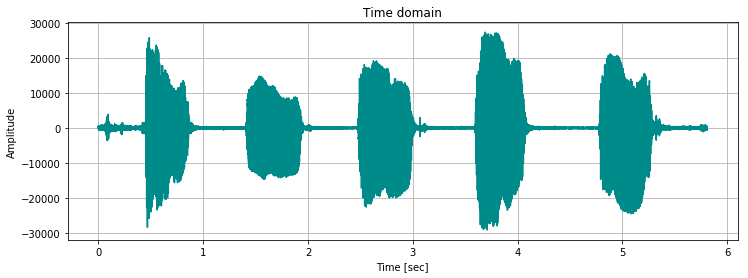

In [5]:
plot_wave(data, fs=fs)

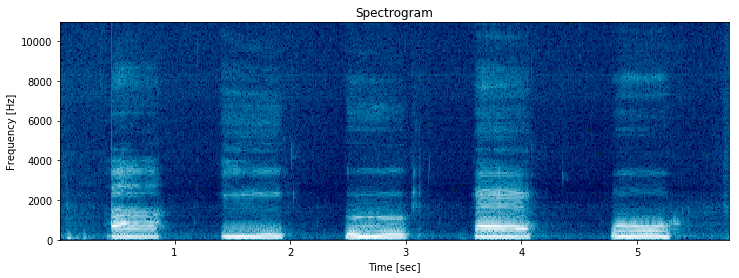

In [6]:
plot_spectrogram(data, fs=fs, nperseg=512, cmap='ocean', band=0.5)

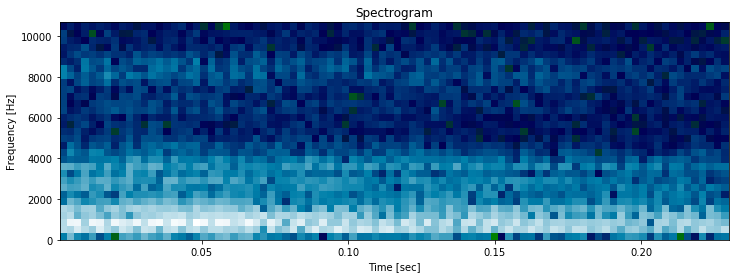

In [7]:
data = data[1024*22:1024*32]
data = data/32768.0  # Normalization
plot_spectrogram(data, fs=fs, nperseg=128, cmap='ocean', band=0.5)

In [8]:
play(data=data, rate=fs)

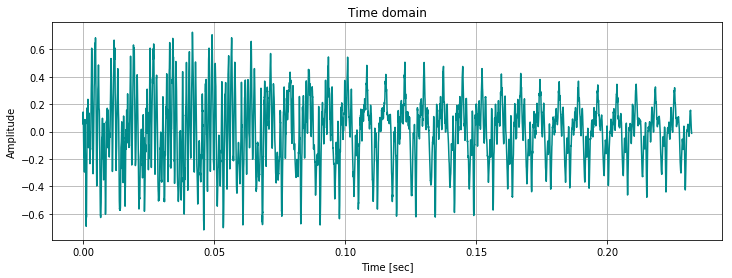

In [9]:
plot_wave(data)

Frequencies at peaks: [137.8125] Hz


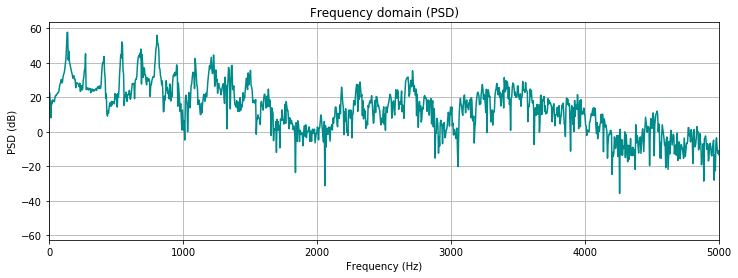

In [12]:
plot_fft(data, mode='psd', xlim=[0,5000])

## Linear prediction

$$ x(n) + a_1 x(n-1) + ... + a_p x(n-p) = e(n) $$

### Auto correlation

$$ R_{ff}(\tau) = \int_{-\infty}^{+\infty} f(t) f(t - \tau) dt $$

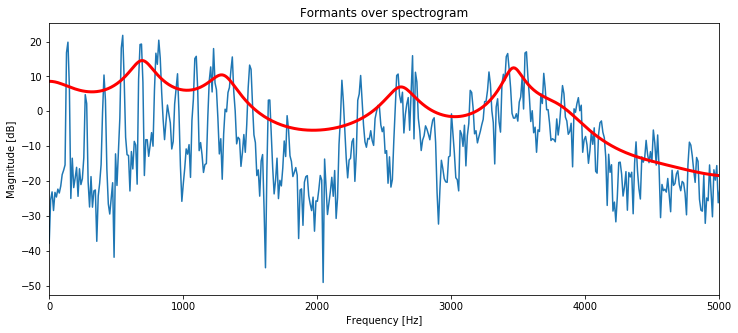

In [13]:
t = np.arange(0, len(data)/fs, 1/fs)

center = len(data) / 2
cuttime = 0.1
cut_len = cuttime * fs
fragment = data[int(center - cut_len/2) : int(center + cut_len/2)]

fragment = preEmphasis(fragment, 0.97)

hammingWindow = np.hamming(len(fragment))
fragment = fragment * hammingWindow

lpcOrder = 64
r = autocorr(fragment, lpcOrder + 1)
a, e  = LevinsonDurbin(r, lpcOrder)

nfft = 4096

freq = fftfreq(nfft, d = 1.0 / fs)[:int(nfft/2)]

mag = np.abs(fft(fragment, nfft))

log_mag = 20 * np.log10(mag)

plt.figure(figsize=[12,5])
plt.plot(freq, log_mag[:int(nfft/2)])

w, h = sg.freqz(np.sqrt(e), a, nfft, "whole")
lpc_mag = np.abs(h)
log_lpc_mag = 20 * np.log10(lpc_mag)
plt.plot(freq, log_lpc_mag[:int(nfft/2)], "r", linewidth=3)

plt.xlim((0, 5000))
plt.title('Formants over spectrogram')
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [Hz]')

plt.show()

## LPC for time-series data

In [14]:
fs, data = read('./aiueo.wav')
data = data.astype(float)/32768.0  # normalization
print('Length of data: {:.1f} sec'.format(len(data) / fs))

Length of data: 5.8 sec


## Splitting data into frames

In [15]:
frame_interval = 0.01  # 10msec
print('Length of data: {} samples, Length of frame: {} samples'.format(len(data), int(frame_interval * fs)))

Length of data: 256161 samples, Length of frame: 441 samples


In [16]:
frame_length = int(frame_interval * fs)
frame_length  # samples

441

In [17]:
def calc_nfft(length):
    for n in range(1,16):
        nfft = 2 ** n
        if nfft >= length:
            return nfft

In [18]:
nfft = calc_nfft(frame_length)
data = data[:int(np.trunc(len(data)/nfft)*nfft)]
frames = np.split(data, len(data)/nfft)
l = len(frames)
len(data), l

(256000, 500)

Text(0.5,1,'FFT')

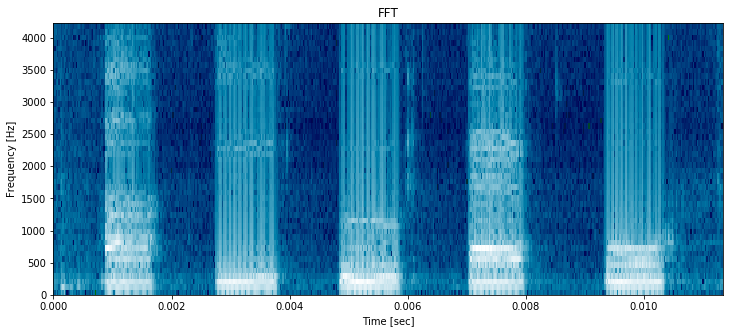

In [19]:
Sxx = fft(frames, n=nfft)
t = np.linspace(0, l/fs, l)
freq = np.linspace(0, fs, nfft)
plt.figure(figsize=[12,5])
plt.pcolormesh(t, freq[:50], 20 * np.log10(np.abs(Sxx.T[:int(nfft/2)][:50])), cmap='ocean')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('FFT')

In [20]:
lpcOrder = 50
R = [autocorr(frame, lpcOrder + 1) for frame in frames]
lpc = np.array([LevinsonDurbin(r, lpcOrder) for r in R])
len(lpc)

500

In [21]:
y = np.array([sg.freqz(np.sqrt(e), a, nfft, "whole") for a,e in lpc])
h = np.array([h for w, h in y])
h.shape

(500, 512)

Text(0.5,0,'Time [sec]')

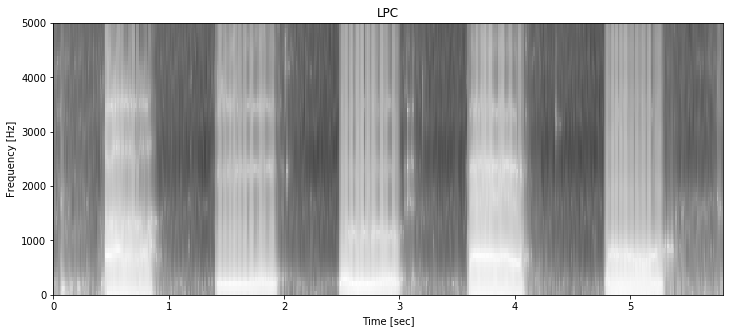

In [22]:
t = np.linspace(0, len(data)/fs, len(h))
freq = np.linspace(0, fs, nfft)

plt.figure(figsize=[12,5])
plt.pcolormesh(t, freq[:int(nfft/2)], 20 * np.log10(np.abs(h.T[:int(nfft/2)])), cmap='Greys_r')
plt.ylim(0,5000)
plt.title('LPC')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

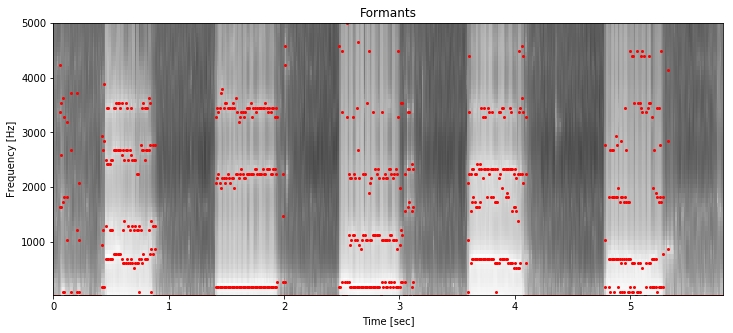

In [23]:
import peakutils
plt.figure(figsize=[12,5])

def idx(h):
    power = 20 * np.log10(np.abs(h)[:80])
    indexes = np.array(peakutils.indexes(power, thres=0.7/max(np.abs(h)))[:3], dtype=int)
    if len(indexes) < 3:
        indexes = np.zeros(3, dtype=int)
    return indexes

indexes = [idx(h) for h in h]
freqs = np.array([[freq[i] for i in idx] for idx in indexes])

plt.pcolormesh(t, freq[:int(nfft/2)], 20 * np.log10(np.abs(h.T[:int(nfft/2)])), cmap='Greys_r')
plt.plot(t, freqs, 'o', color='r' ,markersize=2)
plt.ylim(30,5000)
plt.title('Formants')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')
len(t), len(freq), int(nfft/2)
plt.savefig('formants.jpg')